# 值迭代算法教程：从零实现动态规划

## 📖 为什么需要值迭代？

在学习了 Gymnasium 环境后，我们现在要解决强化学习的核心问题：**如何找到最优策略？**

值迭代（Value Iteration）是一个强大的动态规划算法，它可以：

- 🎯 求解贝尔曼最优方程
- 📈 找到最优状态价值函数 V*(s)
- 🗺️ 推导出最优策略 π*(s)
- ✅ 保证收敛到最优解（在有限MDP中）

## 🎯 本教程目标

我们将从零开始实现值迭代算法，并在一个 4×4 的网格世界中可视化整个学习过程：

- **核心内容**：
  - 理解贝尔曼最优方程
  - 实现值迭代算法的每个步骤
  - 可视化价值函数的收敛过程
  - 生成最优策略的动画演示

- **学习路径**：
  1. 理解值迭代的数学原理
  2. 构建简单的网格世界环境
  3. 实现值迭代核心算法
  4. 可视化学习过程（文本 + 图形 + GIF）
  5. 分析结果并理解最优策略

---

让我们开始这段激动人心的旅程！

## 第一步：安装和导入必要的库

In [1]:
# 导入必要的库
import gymnasium as gym
from gymnasium import spaces
import numpy as np
from typing import Optional, Tuple, Dict, Any, Annotated

# 设置 matplotlib 后端(必须在导入 pyplot 之前)
import matplotlib
matplotlib.use('Agg')  # 使用非交互式后端,适合云端环境

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import display, clear_output, Image as IPImage
import imageio
from io import BytesIO

# 配置 matplotlib 中文显示
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans', 'Arial Unicode MS', 'WenQuanYi Micro Hei']
plt.rcParams['axes.unicode_minus'] = False

print(f"✅ Gymnasium 版本: {gym.__version__}")
print(f"✅ NumPy 版本: {np.__version__}")
print(f"✅ Matplotlib 版本: {matplotlib.__version__}")
print(f"✅ Matplotlib 后端: {matplotlib.get_backend()}")
print(f"✅ 中文字体配置完成")
print(f"✅ imageio 已导入,支持 GIF 动画生成")

✅ Gymnasium 版本: 1.2.1
✅ NumPy 版本: 2.3.3
✅ Matplotlib 版本: 3.10.7
✅ Matplotlib 后端: Agg
✅ 中文字体配置完成
✅ imageio 已导入,支持 GIF 动画生成


## 第二步：导入 GridWorldEnv 环境

我们将使用在 `gymnasium_base.ipynb` 中创建的 `GridWorldEnv` 环境。这个环境提供了：

- 标准的 Gymnasium 接口
- 可自定义的网格大小
- 清晰的观察空间和动作空间
- 文本和图形两种渲染模式

让我们先导入并创建环境：

In [2]:
# 从 gymnasium_base 复制 GridWorldEnv 的定义
class GridWorldEnv(gym.Env):
    """简化的网格世界环境用于值迭代演示"""
    
    def __init__(self, size: Annotated[int, "网格的边长"] = 5):
        super().__init__()
        self.size = size
        
        # 观察空间和动作空间
        self.observation_space = spaces.Dict({
            "agent": spaces.Box(low=0, high=size-1, shape=(2,), dtype=np.int32),
            "target": spaces.Box(low=0, high=size-1, shape=(2,), dtype=np.int32),
        })
        self.action_space = spaces.Discrete(4)  # 0=右, 1=上, 2=左, 3=下
        
        # 动作映射
        self._action_to_direction = {
            0: np.array([1, 0]),   # 右
            1: np.array([0, 1]),   # 上
            2: np.array([-1, 0]),  # 左
            3: np.array([0, -1]),  # 下
        }
        
        self._agent_location = np.array([-1, -1], dtype=np.int32)
        self._target_location = np.array([-1, -1], dtype=np.int32)
    
    def reset(
        self,
        seed: Annotated[Optional[int], "随机数种子,用于保证可重现性"] = None,
        options: Annotated[Optional[dict], "额外的配置选项"] = None,
    ) -> Annotated[Tuple[Dict[str, np.ndarray], Dict[str, float]], "初始观察和额外信息"]:
        super().reset(seed=seed)
        self._agent_location = self.np_random.integers(0, self.size, size=2, dtype=np.int32)
        self._target_location = self._agent_location.copy()
        while np.array_equal(self._target_location, self._agent_location):
            self._target_location = self.np_random.integers(0, self.size, size=2, dtype=np.int32)
        return self._get_obs(), self._get_info()
    
    def step(
        self,
        action: Annotated[int, "要执行的动作编号"],
    ) -> Annotated[Tuple[Dict[str, np.ndarray], float, bool, bool, Dict[str, float]], "新观察、奖励、终止标志、截断标志及额外信息"]:
        direction = self._action_to_direction[action]
        self._agent_location = np.clip(
            self._agent_location + direction, 0, self.size - 1
        )
        terminated = np.array_equal(self._agent_location, self._target_location)
        reward = 1.0 if terminated else 0.0
        return self._get_obs(), reward, terminated, False, self._get_info()
    
    def _get_obs(self) -> Annotated[Dict[str, np.ndarray], "包含agent和target位置的观察字典"]:
        return {"agent": self._agent_location.copy(), "target": self._target_location.copy()}
    
    def _get_info(self) -> Annotated[Dict[str, float], "包含距离信息的字典"]:
        return {"distance": float(np.linalg.norm(self._agent_location - self._target_location, ord=1))}

# 创建环境实例
env = GridWorldEnv(size=5)
print(f"✅ GridWorldEnv 环境创建完成")
print(f"   - 网格大小: {env.size}×{env.size}")
print(f"   - 动作空间: {env.action_space} (0=右, 1=上, 2=左, 3=下)")
print(f"   - 观察空间: agent和target的位置坐标")

✅ GridWorldEnv 环境创建完成
   - 网格大小: 5×5
   - 动作空间: Discrete(4) (0=右, 1=上, 2=左, 3=下)
   - 观察空间: agent和target的位置坐标


## 第三步：理解值迭代算法

### 🧮 贝尔曼最优方程

值迭代算法基于贝尔曼最优方程（Bellman Optimality Equation）：

$$V^*(s) = \max_a \left[ R(s,a) + \gamma \sum_{s'} P(s'|s,a) V^*(s') \right]$$

在确定性环境中简化为：

$$V^*(s) = \max_a \left[ R(s,a) + \gamma V^*(s') \right]$$

### 🔄 值迭代算法流程

1. **初始化**：$V(s) = 0$ for all $s$
2. **迭代更新**：对每个状态计算 $V_{k+1}(s) = \max_a [R(s,a) + \gamma V_k(s')]$
3. **收敛判断**：当 $\max_s |V_{k+1}(s) - V_k(s)| < \theta$ 时停止
4. **策略提取**：$\pi^*(s) = \arg\max_a Q^*(s,a)$

## 第四步：定义环境参数和常量

In [3]:
# --- 环境参数和常量定义 ---
GRID_SIZE = 4  # 网格大小 4×4
GAMMA = 0.9    # 折扣因子
THETA = 0.0001 # 收敛阈值

# 动作定义：上、下、左、右
ACTIONS = ['↑', '↓', '←', '→']

# 动作对应的坐标变化 (row_delta, col_delta)
ACTION_DELTAS = {
    '↑': (-1, 0),  # 向上移动：行减1
    '↓': (1, 0),   # 向下移动：行加1
    '←': (0, -1),  # 向左移动：列减1
    '→': (0, 1)    # 向右移动：列加1
}

print(f"✅ 环境参数配置完成")
print(f"   - 网格大小: {GRID_SIZE}×{GRID_SIZE}")
print(f"   - 折扣因子 γ: {GAMMA}")
print(f"   - 收敛阈值 θ: {THETA}")
print(f"   - 动作空间: {ACTIONS}")

✅ 环境参数配置完成
   - 网格大小: 4×4
   - 折扣因子 γ: 0.9
   - 收敛阈值 θ: 0.0001
   - 动作空间: ['↑', '↓', '←', '→']


## 第五步：初始化环境（奖励矩阵、价值矩阵、策略矩阵）

## 第四步：初始化环境和辅助函数

In [4]:
# --- 2. 环境初始化函数 ---
def initialize_environment() -> Annotated[Tuple[np.ndarray, np.ndarray, np.ndarray], "奖励矩阵、初始价值矩阵(全零)和初始策略矩阵"]:
    """
    初始化迷宫的奖励矩阵和初始价值矩阵。
    - 奖励矩阵根据预设值初始化。
    - 价值矩阵初始化为全零矩阵。
    - 策略矩阵初始化为空,将在迭代中更新。
    
    返回:
        rewards (np.array): 奖励矩阵
        values (np.array): 初始价值矩阵 (全零)
        policies (np.array): 初始策略矩阵 (空)
    """
    rewards = np.array([
        [0, 0, -1, -1],
        [0, -1, -1, 1],
        [0, -1, 0, 0],
        [-1, 0, 0, -1]
    ])
    
    # 初始价值矩阵应为全零矩阵
    values = np.zeros((GRID_SIZE, GRID_SIZE)).astype(float)
    
    # 初始策略矩阵,用空字符串表示未确定的策略
    policies = np.full((GRID_SIZE, GRID_SIZE), '', dtype=object)

    return rewards, values, policies

In [5]:
# --- 3. 辅助函数 ---
def is_valid_state(
    row: Annotated[int, "行索引"],
    col: Annotated[int, "列索引"],
) -> Annotated[bool, "如果状态有效则为True,否则为False"]:
    """
    检查给定状态 (row, col) 是否在迷宫范围内。
    
    参数:
        row (int): 行索引
        col (int): 列索引
        
    返回:
        bool: 如果状态有效则为True,否则为False
    """
    return 0 <= row < GRID_SIZE and 0 <= col < GRID_SIZE

def get_next_state_and_reward(
    current_row: Annotated[int, "当前状态的行索引"],
    current_col: Annotated[int, "当前状态的列索引"],
    action: Annotated[str, "采取的动作 ('↑', '↓', '←', '→')"],
    rewards_matrix: Annotated[np.ndarray, "奖励矩阵"],
) -> Annotated[Tuple[Tuple[int, int], float], "下一个状态的坐标和奖励"]:
    """
    根据当前状态和动作,计算下一个状态的坐标以及从下一个状态获得的奖励。
    如果移动到无效位置,则认为智能体停留在原地。
    
    参数:
        current_row (int): 当前状态的行索引
        current_col (int): 当前状态的列索引
        action (str): 采取的动作 ('↑', '↓', '←', '→')
        rewards_matrix (np.array): 奖励矩阵
        
    返回:
        tuple: (next_row, next_col) 下一个状态的坐标
        float: reward 离开当前状态并到达下一个状态(或停留在原地)所获得的奖励
    """
    delta_row, delta_col = ACTION_DELTAS[action]
    next_row, next_col = current_row + delta_row, current_col + delta_col

    # 如果移动到无效位置,则停留在原地
    if not is_valid_state(next_row, next_col):
        next_row, next_col = current_row, current_col

    # 奖励通常是到达下一个状态后获得的奖励
    reward = rewards_matrix[next_row, next_col] 
    return (next_row, next_col), reward

In [6]:
# --- 4. 核心算法函数 ---
def calculate_q_value(
    row: Annotated[int, "当前状态的行索引"],
    col: Annotated[int, "当前状态的列索引"],
    action: Annotated[str, "采取的动作"],
    rewards_matrix: Annotated[np.ndarray, "奖励矩阵"],
    values_matrix: Annotated[np.ndarray, "当前价值矩阵 (v_k)"],
    gamma: Annotated[float, "折扣因子"],
) -> Annotated[float, "计算出的 Q 值"]:
    """
    计算给定状态 (row, col) 和动作 (action) 的 Q 值。
    假设转移是确定性的 (p(s'|s,a)=1, p(r|s,a)=1)。
    
    参数:
        row (int): 当前状态的行索引
        col (int): 当前状态的列索引
        action (str): 采取的动作
        rewards_matrix (np.array): 奖励矩阵
        values_matrix (np.array): 当前价值矩阵 (v_k)
        gamma (float): 折扣因子
        
    返回:
        float: 计算出的 Q 值
    """
    (next_row, next_col), next_state_reward = get_next_state_and_reward(row, col, action, rewards_matrix)
    
    # Q(s,a) = R_s,a + gamma * V(s')
    # 这里 R_s,a 我们简化为到达 next_state_reward
    q_value = next_state_reward + gamma * values_matrix[next_row, next_col]
    return q_value

def value_iteration_step(
    rewards_matrix: Annotated[np.ndarray, "奖励矩阵"],
    current_values_matrix: Annotated[np.ndarray, "当前迭代的价值矩阵 (v_k)"],
    gamma: Annotated[float, "折扣因子"],
) -> Annotated[Tuple[np.ndarray, np.ndarray, float], "更新后的价值矩阵 (v_{k+1})、策略矩阵 (pi_{k+1})和最大价值变化量"]:
    """
    执行一次价值迭代的步骤,更新价值矩阵和策略矩阵。
    
    参数:
        rewards_matrix (np.array): 奖励矩阵
        current_values_matrix (np.array): 当前迭代的价值矩阵 (v_k)
        gamma (float): 折扣因子
        
    返回:
        new_values_matrix (np.array): 更新后的价值矩阵 (v_{k+1})
        new_policies_matrix (np.array): 更新后的策略矩阵 (pi_{k+1})
        delta (float): 本次迭代中价值函数变化的最大差值
    """
    new_values_matrix = np.copy(current_values_matrix)
    new_policies_matrix = np.full((GRID_SIZE, GRID_SIZE), '', dtype=object)
    
    delta = 0  # 用于记录本次迭代的最大价值变化

    for r in range(GRID_SIZE):
        for c in range(GRID_SIZE):

            max_q_value_for_state = -np.inf # 记录当前状态 s 的最大 Q 值
            best_actions_for_state = []     # 记录导致最大 Q 值的动作

            # 对于当前状态 s,尝试所有可能的动作 a
            for action in ACTIONS:
                q_val = calculate_q_value(r, c, action, rewards_matrix, current_values_matrix, gamma)
                
                # 更新最大 Q 值和对应的动作
                if q_val > max_q_value_for_state:
                    max_q_value_for_state = q_val
                    best_actions_for_state = [action] # 找到更大的 Q 值,清空旧的
                elif q_val == max_q_value_for_state:
                    best_actions_for_state.append(action) # Q 值相同,添加动作

            # 更新当前状态的价值 V_{k+1}(s) = max_a Q(s,a)
            new_values_matrix[r, c] = max_q_value_for_state
            
            # 修正: 策略只显示一个最佳动作。
            # 如果有多个最佳动作,按照优先级选择第一个:↑ > ↓ > ← > →
            if best_actions_for_state:
                # 按照ACTIONS列表中定义的优先级来选择第一个最佳动作
                chosen_policy_action = ''
                for preferred_action in ACTIONS:
                    if preferred_action in best_actions_for_state:
                        chosen_policy_action = preferred_action
                        break
                new_policies_matrix[r, c] = chosen_policy_action
            else:
                new_policies_matrix[r, c] = '' # 没有找到最佳动作 (不应发生,除非无动作)

            # 计算最大变化量 ||v_k - v_{k-1}||_inf
            delta = max(delta, abs(new_values_matrix[r, c] - current_values_matrix[r, c]))

    return new_values_matrix, new_policies_matrix, delta

## 第六步：实现值迭代核心算法

In [7]:
# --- 可视化函数(使用 gymnasium_base.ipynb 的渲染方式) ---

def render_value_iteration_to_array(
    rewards: Annotated[np.ndarray, "奖励矩阵"],
    values: Annotated[np.ndarray, "当前价值矩阵"],
    policies: Annotated[np.ndarray, "当前策略矩阵"],
    iteration: Annotated[int, "迭代次数"],
) -> Annotated[np.ndarray, "shape 为 (height, width, 3) 的 RGB 数组"]:
    """
    将当前值迭代状态渲染为 RGB 数组(用于 GIF 生成)
    使用与 gymnasium_base.ipynb 相同的渲染方式
    
    参数:
        rewards: 奖励矩阵
        values: 当前价值矩阵
        policies: 当前策略矩阵
        iteration: 迭代次数
        
    返回:
        rgb_array: shape 为 (height, width, 3) 的 numpy 数组
    """
    from matplotlib.colors import LinearSegmentedColormap
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), dpi=80)
    
    # 配色方案
    reward_cmap = LinearSegmentedColormap.from_list('reward', ['red', 'white', 'green'])
    value_cmap = 'viridis'
    
    # 1. 绘制奖励矩阵(使用英文避免渲染问题)
    ax1 = axes[0]
    im1 = ax1.imshow(rewards, cmap=reward_cmap, vmin=-1, vmax=1)
    ax1.set_title(f'Reward Matrix', fontsize=14, fontweight='bold')
    ax1.set_xticks(range(GRID_SIZE))
    ax1.set_yticks(range(GRID_SIZE))
    
    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            ax1.text(j, i, f'{rewards[i, j]:.0f}',
                    ha="center", va="center", color="black", fontsize=12)
    
    plt.colorbar(im1, ax=ax1, fraction=0.046)
    
    # 2. 绘制价值矩阵(使用英文)
    ax2 = axes[1]
    im2 = ax2.imshow(values, cmap=value_cmap)
    ax2.set_title(f'Value Matrix V{iteration}', fontsize=14, fontweight='bold')
    ax2.set_xticks(range(GRID_SIZE))
    ax2.set_yticks(range(GRID_SIZE))
    
    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            ax2.text(j, i, f'{values[i, j]:.2f}',
                    ha="center", va="center", 
                    color="white" if values[i, j] < (values.max()/2 if values.max() > 0 else 0.5) else "black",
                    fontsize=10)
    
    plt.colorbar(im2, ax=ax2, fraction=0.046)
    
    # 3. 绘制策略矩阵(使用英文)
    ax3 = axes[2]
    policy_display = np.zeros((GRID_SIZE, GRID_SIZE))
    im3 = ax3.imshow(policy_display, cmap='gray', vmin=0, vmax=1, alpha=0.1)
    ax3.set_title(f'Policy Matrix pi{iteration}', fontsize=14, fontweight='bold')
    ax3.set_xticks(range(GRID_SIZE))
    ax3.set_yticks(range(GRID_SIZE))
    
    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            if policies[i, j]:
                ax3.text(j, i, policies[i, j],
                        ha="center", va="center", 
                        color="blue", fontsize=24, fontweight='bold')
    
    # 整体标题(使用英文避免中文渲染问题)
    fig.suptitle(f'Value Iteration: Iteration {iteration}', fontsize=16, fontweight='bold', y=0.98)
    
    plt.tight_layout()
    
    # 转换为 RGB 数组(与 gymnasium_base.ipynb 相同的方式)
    fig.canvas.draw()
    buf = fig.canvas.buffer_rgba()
    rgb_array = np.asarray(buf)
    rgb_array = rgb_array[:, :, :3]  # RGBA to RGB
    plt.close(fig)
    
    return rgb_array

print("✅ 可视化函数定义完成")
print("   - render_value_iteration_to_array: 渲染为 RGB 数组(用于 GIF)")

✅ 可视化函数定义完成
   - render_value_iteration_to_array: 渲染为 RGB 数组(用于 GIF)


## 第七步：实现可视化函数（使用 gymnasium_base 的渲染方式）

我们将使用与 `gymnasium_base.ipynb` 相同的渲染方式来生成 GIF 动画，展示值迭代的收敛过程。

In [8]:
# --- 主执行函数(带 GIF 动画生成,使用 gymnasium_base 的方式) ---

def create_value_iteration_gif(
    gif_filename: Annotated[str, "GIF文件名"] = 'value_iteration.gif',
    fps: Annotated[int, "每秒帧数"] = 2,
    show_text: Annotated[bool, "是否显示文本输出"] = True,
) -> Annotated[Tuple[np.ndarray, np.ndarray, np.ndarray, int], "奖励矩阵、最终价值矩阵、最优策略矩阵和迭代次数"]:
    """
    执行值迭代并生成 GIF 动画
    
    参数:
        gif_filename: GIF 文件名
        fps: 每秒帧数
        show_text: 是否显示文本输出
        
    返回:
        rewards: 奖励矩阵
        values: 最终价值矩阵
        policies: 最优策略矩阵
        iteration_count: 迭代次数
    """
    # 1. 初始化环境
    rewards, values, policies = initialize_environment()
    
    if show_text:
        print("=" * 70)
        print("🚀 值迭代算法启动".center(70))
        print("=" * 70)
    
    # 用于存储 GIF 帧
    frames = []
    
    # 添加初始状态帧
    print(f"生成第 0 帧...")
    frames.append(render_value_iteration_to_array(rewards, values, policies, 0))
    
    iteration = 0
    delta = float('inf')
    
    # 2. 迭代直到收敛
    while delta > THETA:
        iteration += 1
        
        # 执行一次值迭代步骤
        values, policies, delta = value_iteration_step(rewards, values, GAMMA)
        
        # 生成当前迭代的帧
        print(f"生成第 {iteration} 帧...")
        frames.append(render_value_iteration_to_array(rewards, values, policies, iteration))
        
        if show_text and iteration <= 5:  # 只显示前5次迭代的文本
            print(f"\\n迭代 {iteration}: Delta = {delta:.6f}")
    
    # 3. 输出最终结果
    if show_text:
        print(f"\\n{'=' * 70}")
        print("🎉 值迭代收敛完成！".center(70))
        print(f"{'=' * 70}")
        print(f"✅ 总计迭代次数: {iteration}")
        print(f"✅ 最终收敛误差: {delta:.6f}")
    
    # 4. 在结尾多添加几帧以便观察最终结果
    for _ in range(5):
        frames.append(render_value_iteration_to_array(rewards, values, policies, iteration))
    
    # 5. 保存 GIF(使用与 gymnasium_base.ipynb 相同的方式)
    print(f"\\n正在保存 GIF(共 {len(frames)} 帧)...")
    imageio.mimsave(gif_filename, frames, fps=fps, loop=0)
    
    print(f"\\n✅ GIF 动画已保存: {gif_filename}")
    print(f"   - 总帧数: {len(frames)}")
    print(f"   - 帧率: {fps} fps")
    print(f"   - 迭代过程: 0 → {iteration}")
    
    return rewards, values, policies, iteration

print("✅ 主执行函数定义完成")
print("   - create_value_iteration_gif: 执行值迭代并生成 GIF 动画")

✅ 主执行函数定义完成
   - create_value_iteration_gif: 执行值迭代并生成 GIF 动画


## 第八步：执行值迭代并生成 GIF 动画

                              🚀 值迭代算法启动                               
生成第 0 帧...


生成第 1 帧...
\n迭代 1: Delta = 1.000000
生成第 2 帧...
\n迭代 2: Delta = 0.900000
生成第 3 帧...
\n迭代 3: Delta = 0.810000
生成第 4 帧...
\n迭代 4: Delta = 0.729000
生成第 5 帧...
\n迭代 5: Delta = 0.656100
生成第 6 帧...
生成第 7 帧...
生成第 8 帧...
生成第 9 帧...
生成第 10 帧...
生成第 11 帧...
生成第 12 帧...
生成第 13 帧...
生成第 14 帧...
生成第 15 帧...
生成第 16 帧...
生成第 17 帧...
生成第 18 帧...
生成第 19 帧...
生成第 20 帧...
生成第 21 帧...
生成第 22 帧...
生成第 23 帧...
生成第 24 帧...
生成第 25 帧...
生成第 26 帧...
生成第 27 帧...
生成第 28 帧...
生成第 29 帧...
生成第 30 帧...
生成第 31 帧...
生成第 32 帧...
生成第 33 帧...
生成第 34 帧...
生成第 35 帧...
生成第 36 帧...
生成第 37 帧...
生成第 38 帧...
生成第 39 帧...
生成第 40 帧...
生成第 41 帧...
生成第 42 帧...
生成第 43 帧...
生成第 44 帧...
生成第 45 帧...
生成第 46 帧...
生成第 47 帧...
生成第 48 帧...
生成第 49 帧...
生成第 50 帧...
生成第 51 帧...
生成第 52 帧...
生成第 53 帧...
生成第 54 帧...
生成第 55 帧...
生成第 56 帧...
生成第 57 帧...
生成第 58 帧...
生成第 59 帧...
生成第 60 帧...
生成第 61 帧...
生成第 62 帧...
生成第 63 帧...
生成第 64 帧...
生成第 65 帧...
生成第 66 帧...
生成第 67 帧...
生成第 68 帧...
生成第 69 帧...
生成第 70 帧...
生成第 71 帧...
生成第 72 帧...
生成第 73 帧...
生成第 74 帧

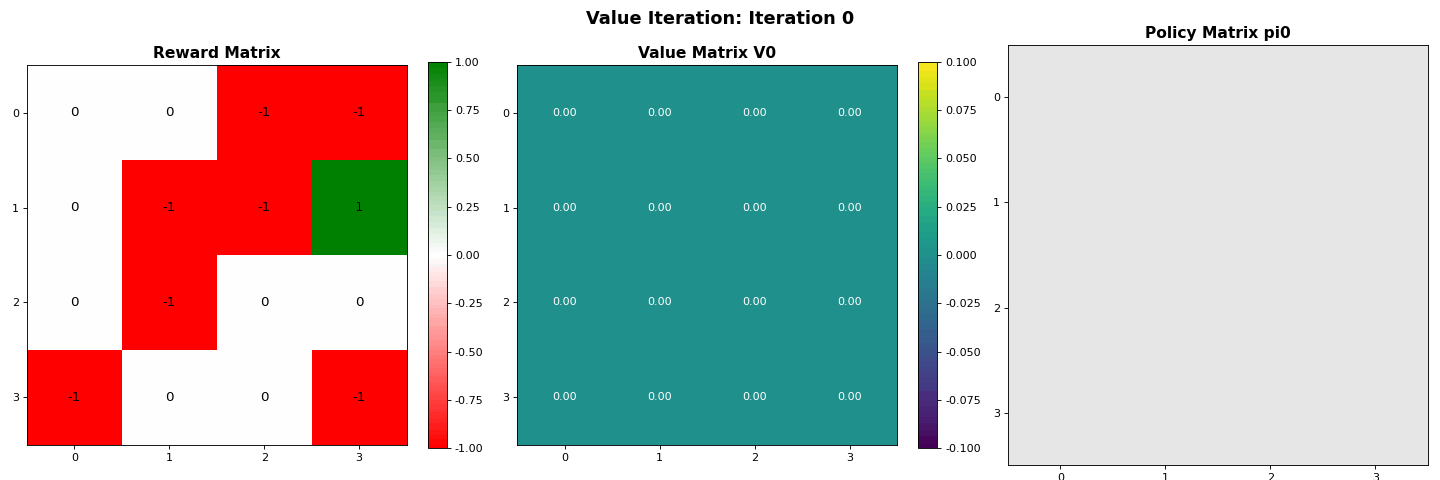

In [9]:
# 执行值迭代并生成 GIF 动画
rewards, values, policies, iterations = create_value_iteration_gif(
    gif_filename='value_iteration.gif',
    fps=2,
    show_text=True
)

# 在 Jupyter 中显示 GIF（使用与 gymnasium_base.ipynb 相同的方式）
print(f"\\n正在显示 GIF...")
display(IPImage(filename='value_iteration.gif'))

## 📚 总结与分析

### 🎯 你学到了什么

通过这个教程，你已经完整实现了值迭代算法，并可视化了整个学习过程：

1. **贝尔曼最优方程**的实际应用
   - 理解了如何通过迭代更新价值函数
   - 看到了价值函数如何逐步收敛到最优解

2. **值迭代算法的工作原理**
   - 初始化：所有状态的价值为 0
   - 迭代更新：基于贝尔曼最优方程更新每个状态的价值
   - 策略提取：根据最优价值函数得到最优策略
   - 收敛判断：当价值变化小于阈值时停止

3. **可视化的重要性**
   - GIF 动画清晰地展示了算法的收敛过程
   - 可以观察到价值函数如何从全零逐步更新
   - 可以看到策略如何从空策略变为最优策略

### 🔍 观察结果

从生成的 GIF 动画中，你可以观察到：

- **价值传播**：奖励高的状态（+1）周围的价值逐渐增大
- **策略形成**：箭头逐渐指向高价值的状态
- **收敛过程**：价值函数的变化逐渐减小，最终稳定

### 🎓 下一步学习

现在你已经掌握了值迭代，可以继续学习：

1. **策略迭代算法**
   - 对比值迭代和策略迭代的异同
   - 理解两种算法的优缺点

2. **更复杂的环境**
   - 添加障碍物
   - 增加状态空间
   - 引入随机性（随机 MDP）

3. **实际应用**
   - 路径规划
   - 资源分配
   - 游戏AI

---

**恭喜你完成了值迭代算法的学习！** 🎉